In [34]:

import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Text processing libraries
import re
import string
from tqdm import tqdm

# Natural Language Toolkit (NLP)
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# Word cloud visualization
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_fake=pd.read_csv("/kaggle/input/fake-news-detection/Fake.csv")
data_true=pd.read_csv("/kaggle/input/fake-news-detection/True.csv")
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
data_fake.shape,data_true.shape

((23481, 4), (21417, 4))

##  As target feature Insart a column "class"

In [5]:
data_fake["class"] = 0
data_true["class"] = 1

In [6]:
data_fake.shape,data_true.shape

((23481, 5), (21417, 5))

## Merging True and Fake Dataframes

In [7]:
data_merge = pd.concat([data_fake, data_true], axis =0 )
data_merge.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


### As the title, subject and date column will not going to be helpful in identification of the news. So, we can drop these column.

In [8]:
data_merge = data_merge.drop(["title", "subject","date"], axis = 1)


In [9]:
data_merge.isnull().sum()

text     0
class    0
dtype: int64

## Shuffle the dataset

In [10]:
data_merge = data_merge.sample(frac=1, random_state=42).reset_index(drop=True)

## Visualizing the unique values

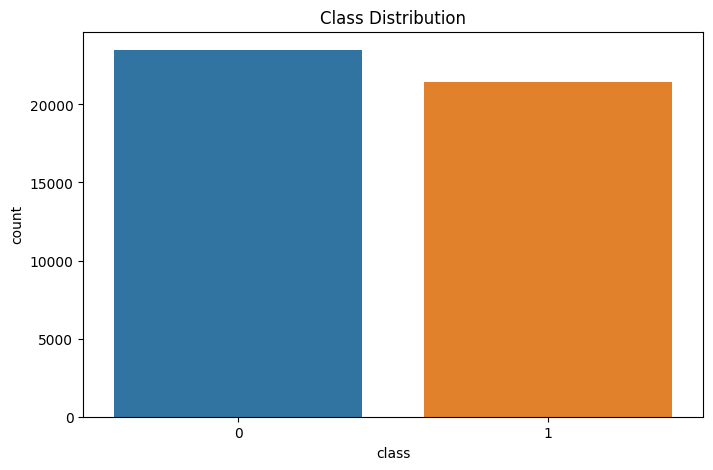

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=data_merge,
    x="class",   
    order=data_merge["class"].value_counts().index
)
plt.xticks()
plt.title("Class Distribution")
plt.show()


## Deafine a Preprocessing Function 

In [12]:
def preprocess_text(text_data):
    preprocessed_text = []
    
    for sentence in tqdm(text_data, desc="Preprocessing"):
        # Remove punctuation and special characters
        sentence = re.sub(r'[^\w\s]', '', sentence)
        
        # Remove stopwords and convert to lowercase
        filtered_words = [
            word.lower()
            for word in sentence.split()
            if word.lower() not in stopwords.words('english')
        ]
        
        # Reconstruct the cleaned sentence
        preprocessed_text.append(" ".join(filtered_words))
    
    return preprocessed_text


## Apply Preprocessing to Dataset 

In [13]:
# Apply preprocessing to the "text" column
preprocessed_review = preprocess_text(data_merge['text'].values)

# Replace the original text column with cleaned version
data_merge['text'] = preprocessed_review



Preprocessing: 100%|██████████| 44898/44898 [25:13<00:00, 29.67it/s] 


## WordCould for Fake news

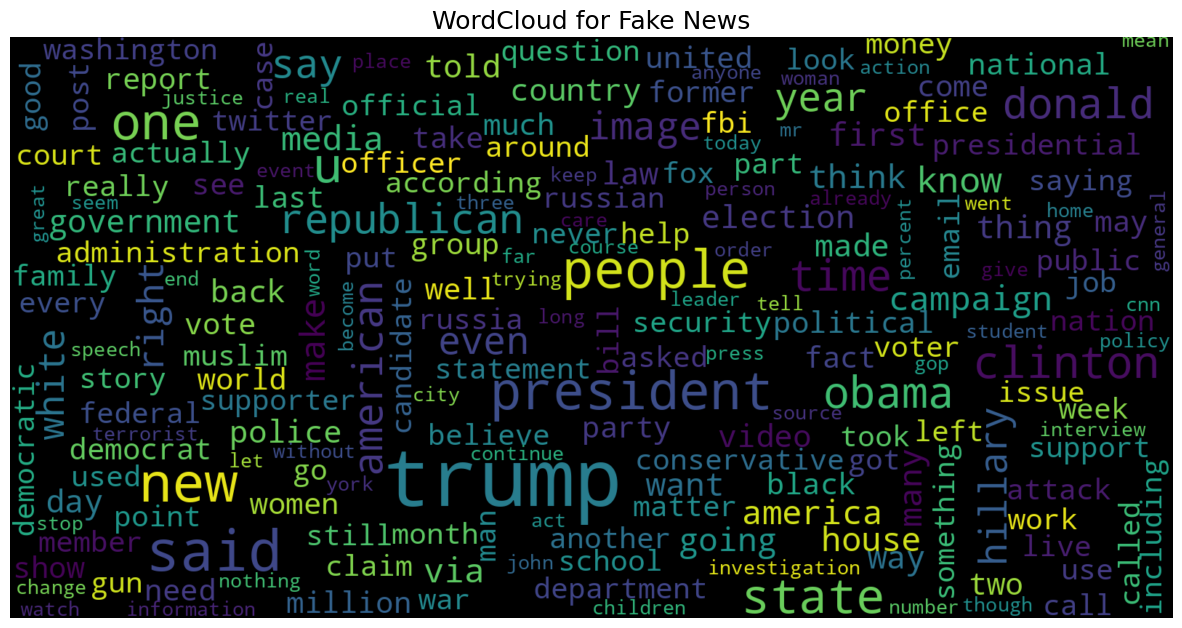

In [14]:
consolidated_fake = " ".join(
    word for word in data_merge['text'][data_merge['class'] == 0].astype(str)
)

wordcloud_fake = WordCloud(
    width=1600, height=800,
    random_state=21, max_font_size=110,
    collocations=False
).generate(consolidated_fake)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud for Fake News", fontsize=18)
plt.show()


## Bar Graph of Top 20 Frequent Words

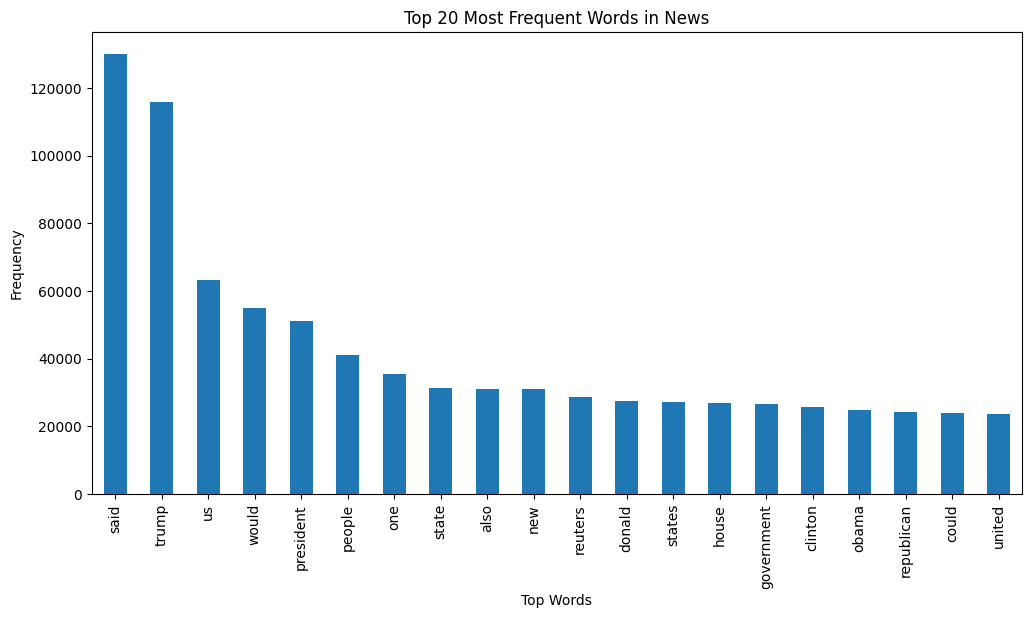

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    # Sum up word counts
    sum_words = bag_of_words.sum(axis=0)
    
    # Map words to their counts
    words_freq = [
        (word, sum_words[0, idx])
        for word, idx in vec.vocabulary_.items()
    ]
    
    # Sort in descending order of frequency
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 20 words
common_words = get_top_n_words(data_merge['text'], 20)

# Convert to DataFrame
df1 = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot bar chart
df1.groupby('Word').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(12, 6),
    xlabel="Top Words",
    ylabel="Frequency",
    title="Top 20 Most Frequent Words in News"
)
plt.show()


## Train Test Splite

In [21]:
x_train, x_test, y_train, y_test = train_test_split(data_merge['text'], 
                                                    data_merge['class'], 
                                                    test_size=0.20)

## Converting traing data into Vector String 

In [31]:
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

## Model Training 

In [32]:

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9932345898992149
0.9871937639198218


## Confusion Matrix

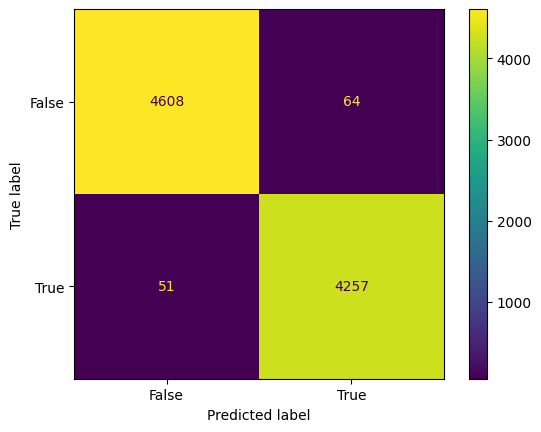

In [35]:
# Confusion matrix of Results from Decision Tree classification
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])

cm_display.plot()
plt.show()